In [1]:
import re
import gc
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import mode
import scipy.stats as stats

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgb
from lightgbm import plot_importance

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("train.csv")
df_train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [3]:
df_test = pd.read_csv("test.csv")
df_test.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,NaN,66,2017-04-18,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...,2020.0
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состо...",3000.0,4,2017-04-16,Private,NaN,NaN
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,Продам новый телевизор BBK 32 диагональ смарт...,15000.0,15,2017-04-17,Private,8c361112cb049745ef2d1b0ae73594fc5c107286b0c942...,2960.0
3,8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,"Продам новую вытяжку в упаковке,с документами....",4500.0,70,2017-04-17,Private,NaN,NaN
4,8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,Продам отличную коляску. б/у 1 год. все вопрос...,4900.0,15,2017-04-15,Private,bc3cf6deef10840fc302e38eb48fa7748aa1e28d534f8f...,1002.0


In [4]:
df_all = pd.concat([df_train, df_test], axis = 0)

In [5]:
df_train.shape, df_test.shape, df_all.shape

((1503424, 18), (508438, 17), (2011862, 18))

In [6]:
gc.collect()

11

In [7]:
# train_active = pd.read_csv('train_active.csv')

In [8]:
# train_active.head()

In [9]:
# gc.collect()

In [10]:
# test_active = pd.read_csv('test_active.csv')

In [11]:
# test_active.head()

In [12]:
# train_active.shape, test_active.shape

In [13]:
periods_test = pd.read_csv('periods_test.csv')

In [14]:
periods_test.head()

,item_id,activation_date,date_from,date_to
0,f3a62a713278,2017-03-13,2017-04-12,2017-04-12
1,045ec5dabe07,2017-04-03,2017-04-12,2017-04-18
2,801d15e12e25,2017-04-17,2017-04-17,2017-04-18
3,0a981789d4af,2017-03-23,2017-04-12,2017-04-18
4,cab2ed403350,2017-03-28,2017-04-12,2017-04-18


In [15]:
periods_train = pd.read_csv('periods_train.csv')

In [16]:
periods_train.head()

,item_id,activation_date,date_from,date_to
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28


In [17]:
periods_train.shape, periods_test.shape, 

((16687412, 4), (13724922, 4))

In [18]:
df_train.isnull().sum()

item_id                      0
user_id                      0
region                       0
city                         0
parent_category_name         0
category_name                0
param_1                  61576
param_2                 654542
param_3                 862565
title                        0
description             116276
price                    85362
item_seq_number              0
activation_date              0
user_type                    0
image                   112588
image_top_1             112588
deal_probability             0
dtype: int64

In [19]:
df_test.isnull().sum()

item_id                      0
user_id                      0
region                       0
city                         0
parent_category_name         0
category_name                0
param_1                  22910
param_2                 233229
param_3                 306331
title                        0
description                  0
price                    30585
item_seq_number              0
activation_date              0
user_type                    0
image                    42609
image_top_1              42609
dtype: int64

In [20]:
target = df_train.deal_probability

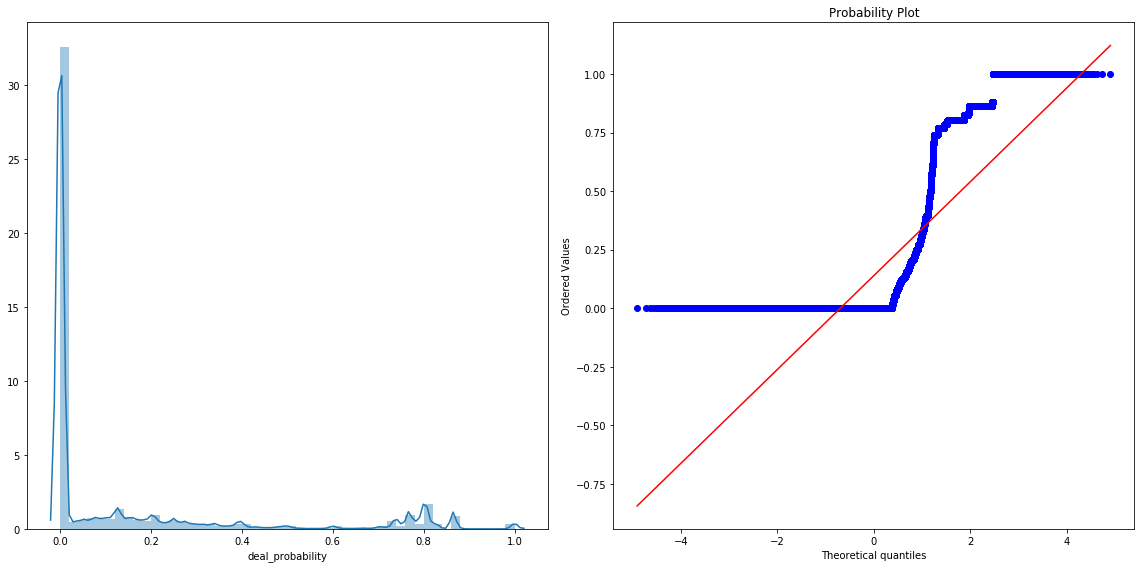

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.distplot(target)
plt.subplot(122)
stats.probplot(target, plot=plt)
plt.tight_layout()
plt.show()

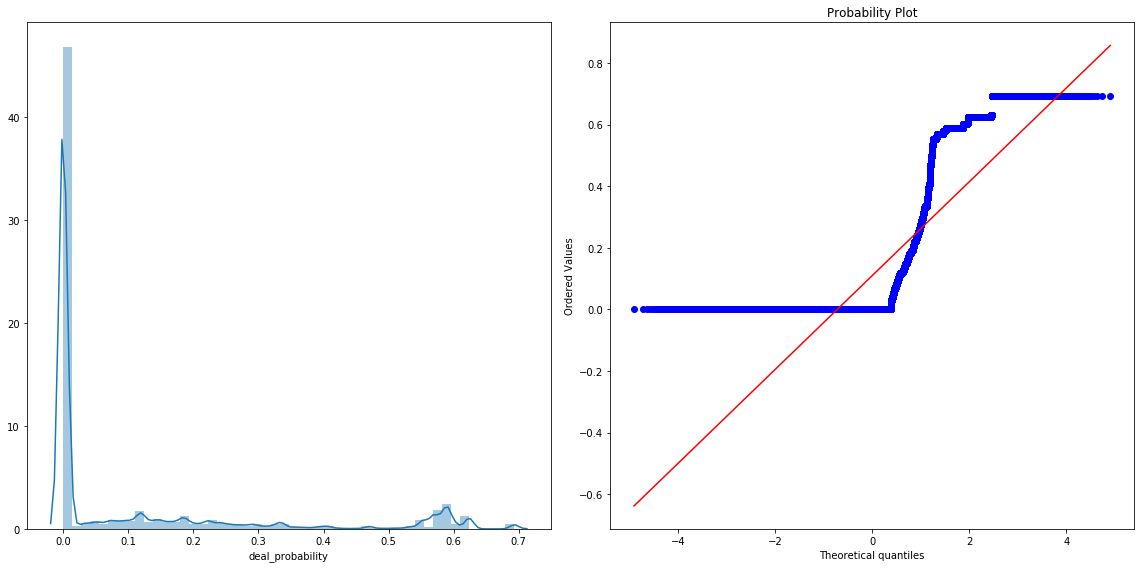

In [22]:
#logigramatic trip duration data#logigra 
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.distplot(np.log(target + 1))
plt.subplot(122)
stats.probplot(np.log(target + 1), plot=plt)
plt.tight_layout()
plt.show()

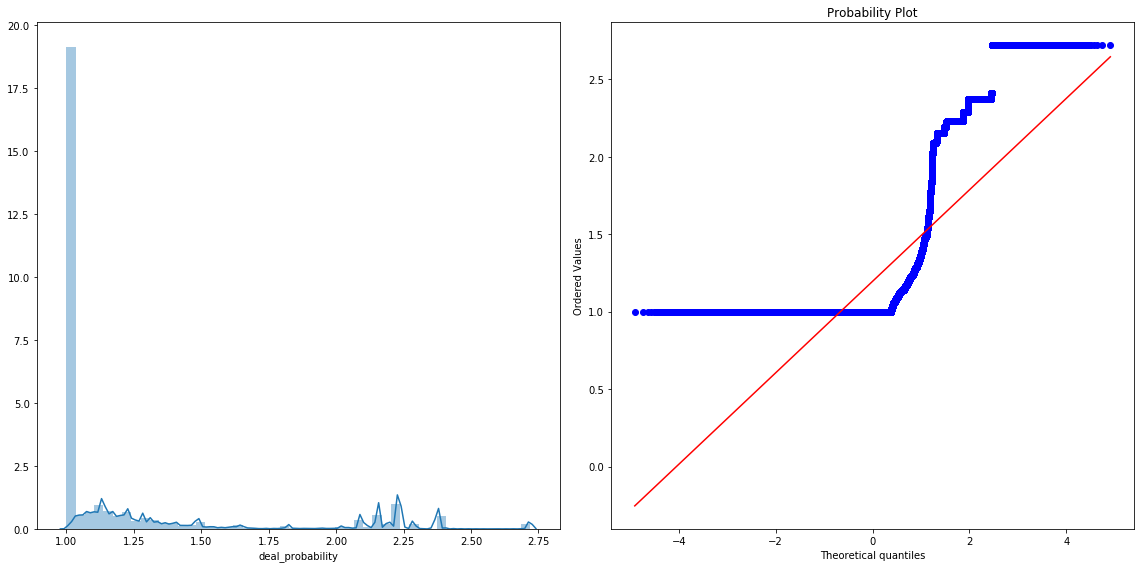

In [23]:
#logigramatic trip duration data#logigra 
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.distplot(np.exp(target))
plt.subplot(122)
stats.probplot(np.exp(target), plot=plt)
plt.tight_layout()
plt.show()

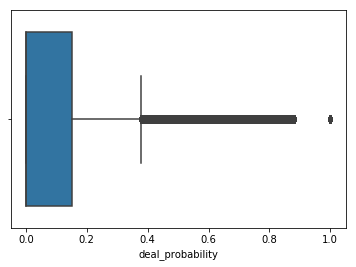

In [24]:
sns.boxplot(x=target, )
plt.show()

In [25]:
print("0 deal probability : ", round(len(target[target == 0]) / len(target), 2))
print("1 deal probability : ", round(len(target[target == 1]) / len(target), 2))

0 deal probability :  0.65
1 deal probability :  0.01


# categorical data list counts

In [26]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011862 entries, 0 to 508437
Data columns (total 18 columns):
activation_date         object
category_name           object
city                    object
deal_probability        float64
description             object
image                   object
image_top_1             float64
item_id                 object
item_seq_number         int64
param_1                 object
param_2                 object
param_3                 object
parent_category_name    object
price                   float64
region                  object
title                   object
user_id                 object
user_type               object
dtypes: float64(3), int64(1), object(14)
memory usage: 291.6+ MB


# region

# of category :  28


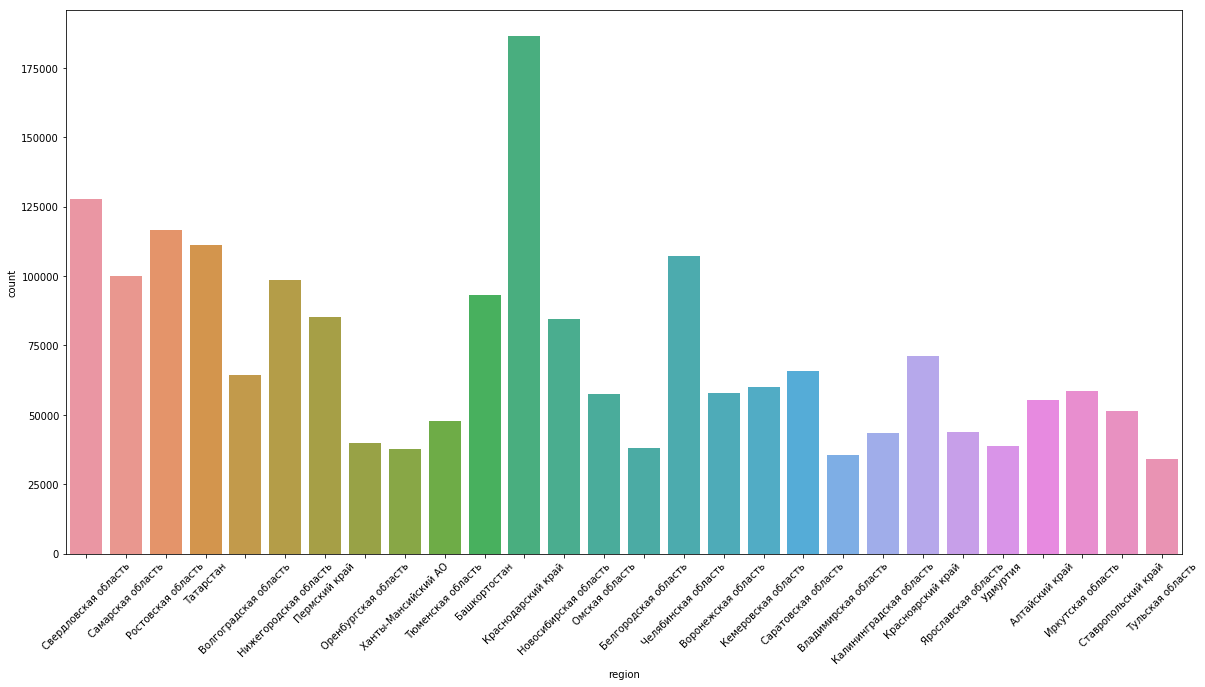

In [27]:
print('# of category : ', len(df_all.region.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_all.region, data=df_all)
plt.show()

# city

# of category :  1752


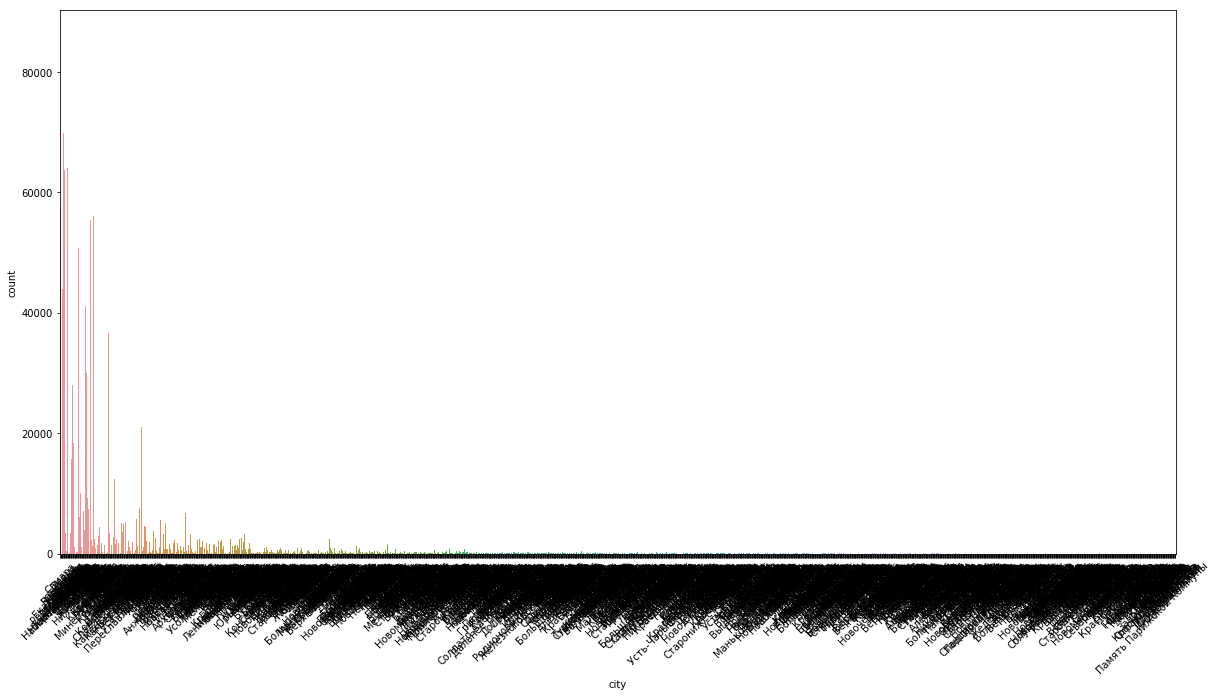

In [28]:
print('# of category : ', len(df_all.city.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_all.city, data=df_all)
plt.show()

# parent_category_name

# of category :  9


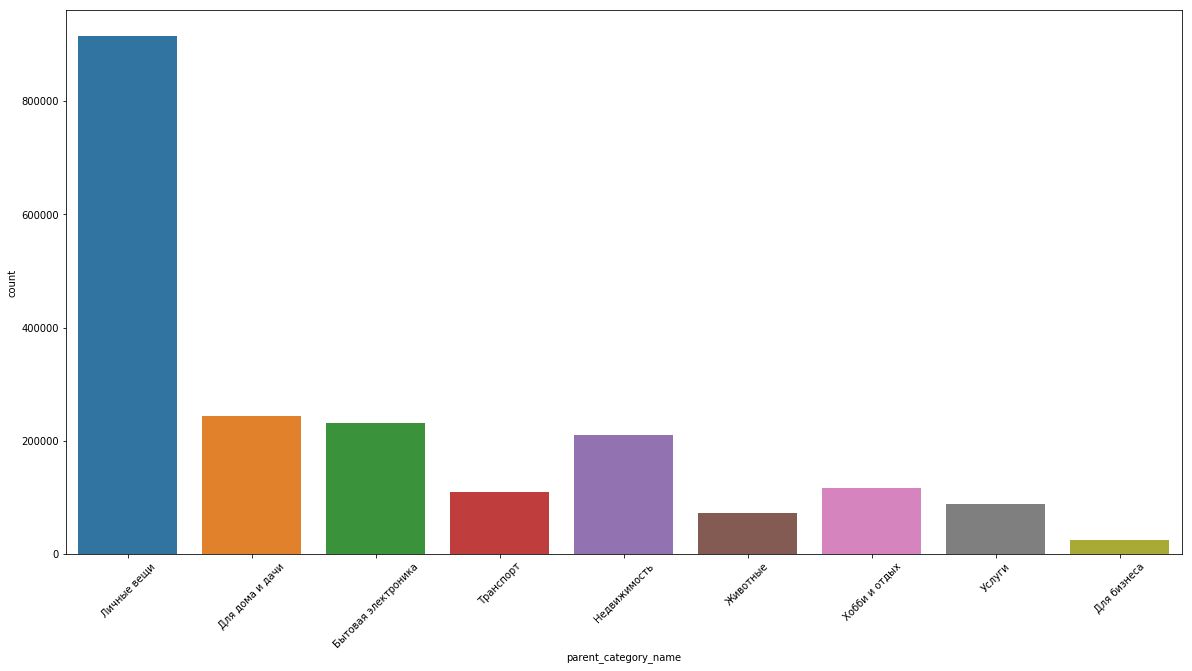

In [29]:
print('# of category : ', len(df_all.parent_category_name.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_all.parent_category_name, data=df_all)
plt.show()

# category_name

# of category :  47


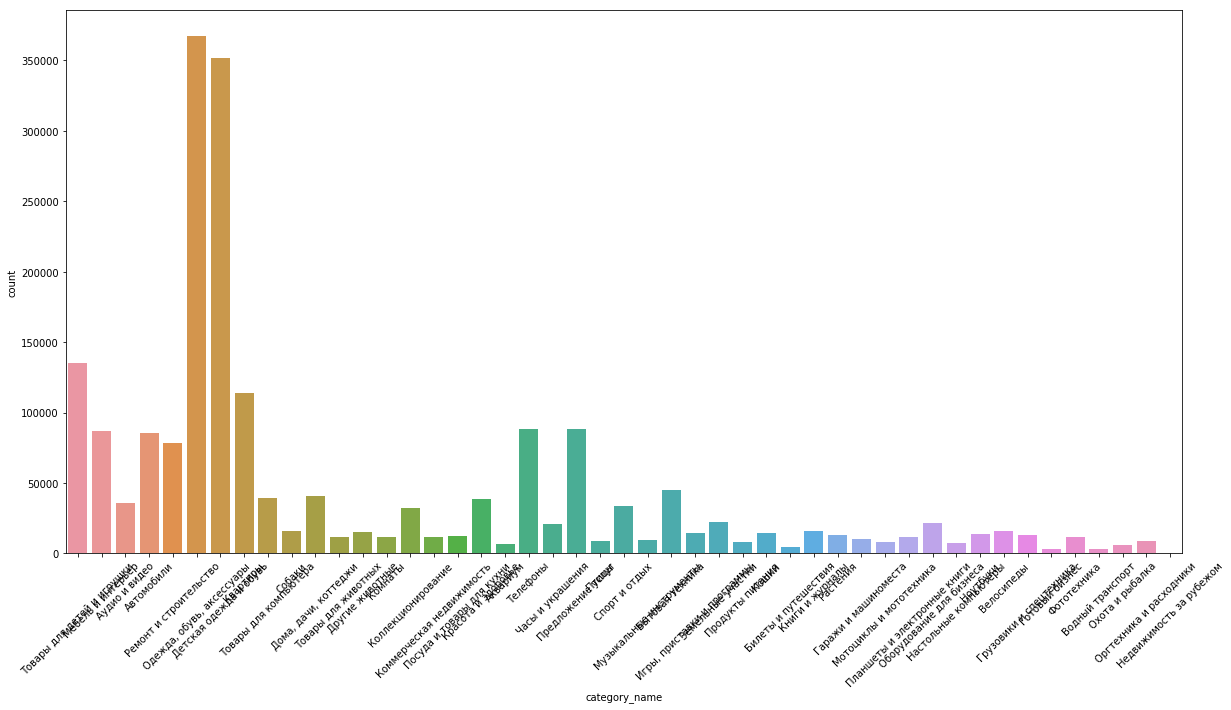

In [30]:
print('# of category : ', len(df_all.category_name.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_all.category_name, data=df_all)
plt.show()

# param_1

# of category :  371


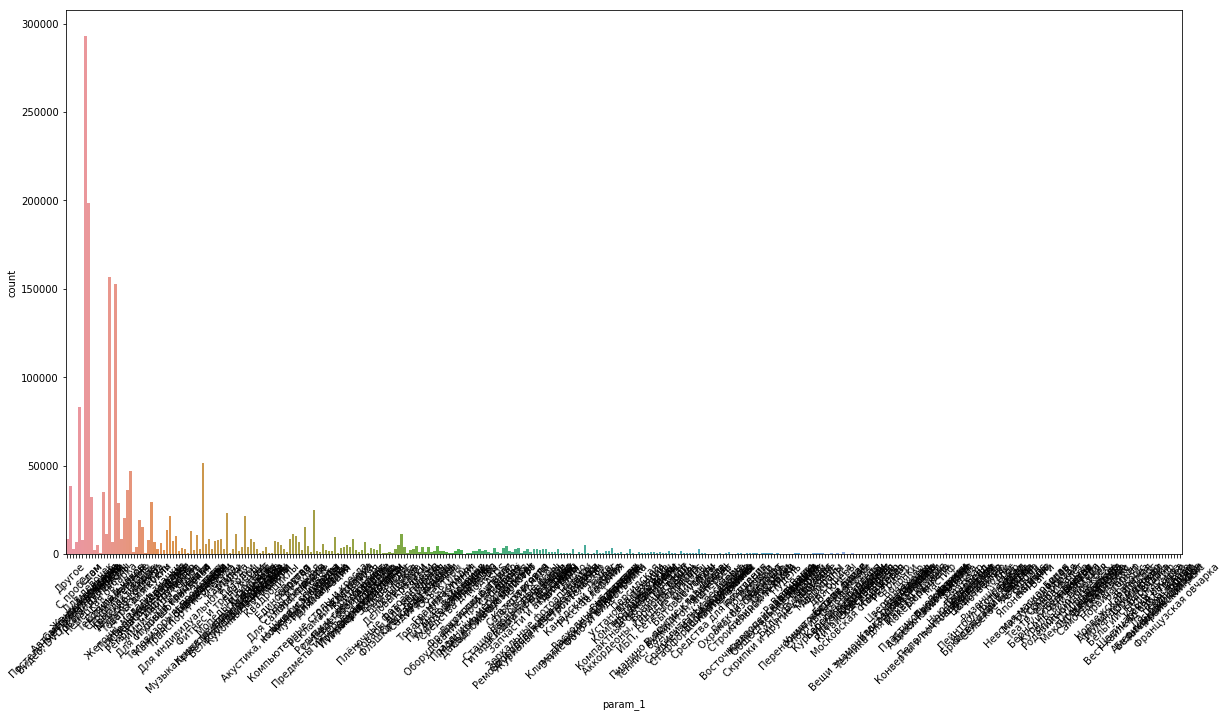

In [31]:
print('# of category : ', len(df_all.param_1.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_all.param_1, data=df_all)
plt.show()

# param_2

# of category :  277


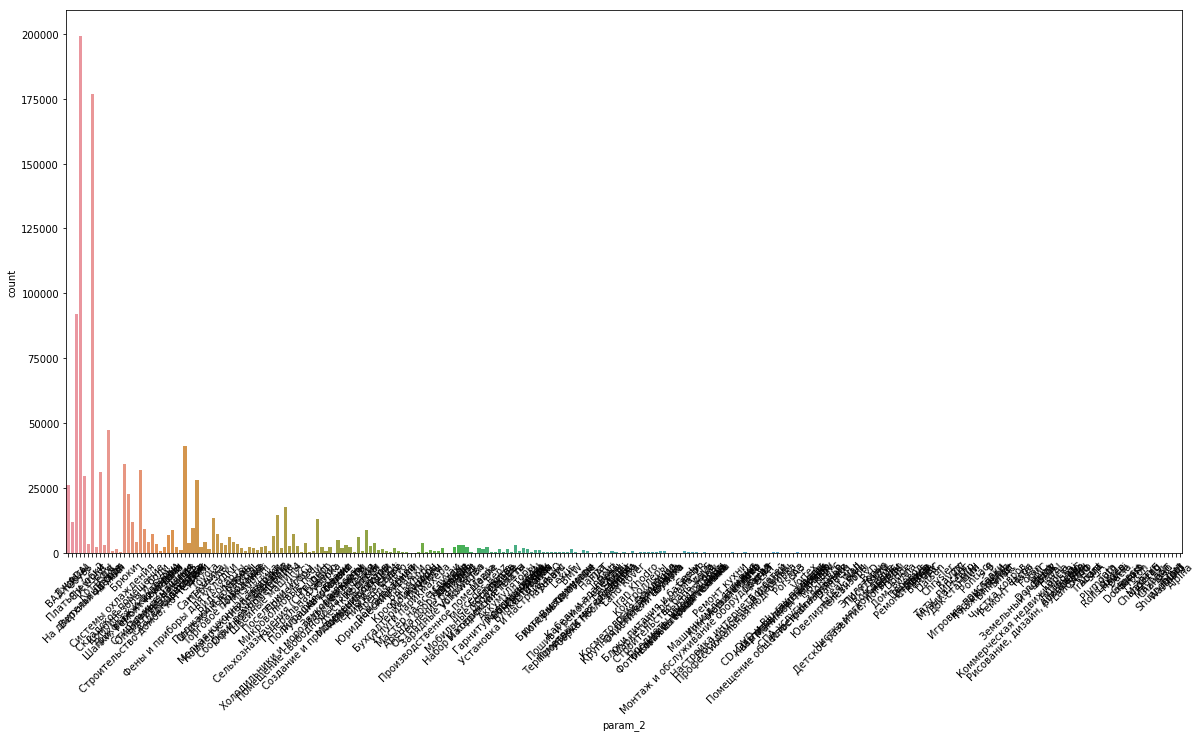

In [32]:
print('# of category : ', len(df_all.param_2.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_all.param_2, data=df_all)
plt.show()

# param_3

# of category :  1276


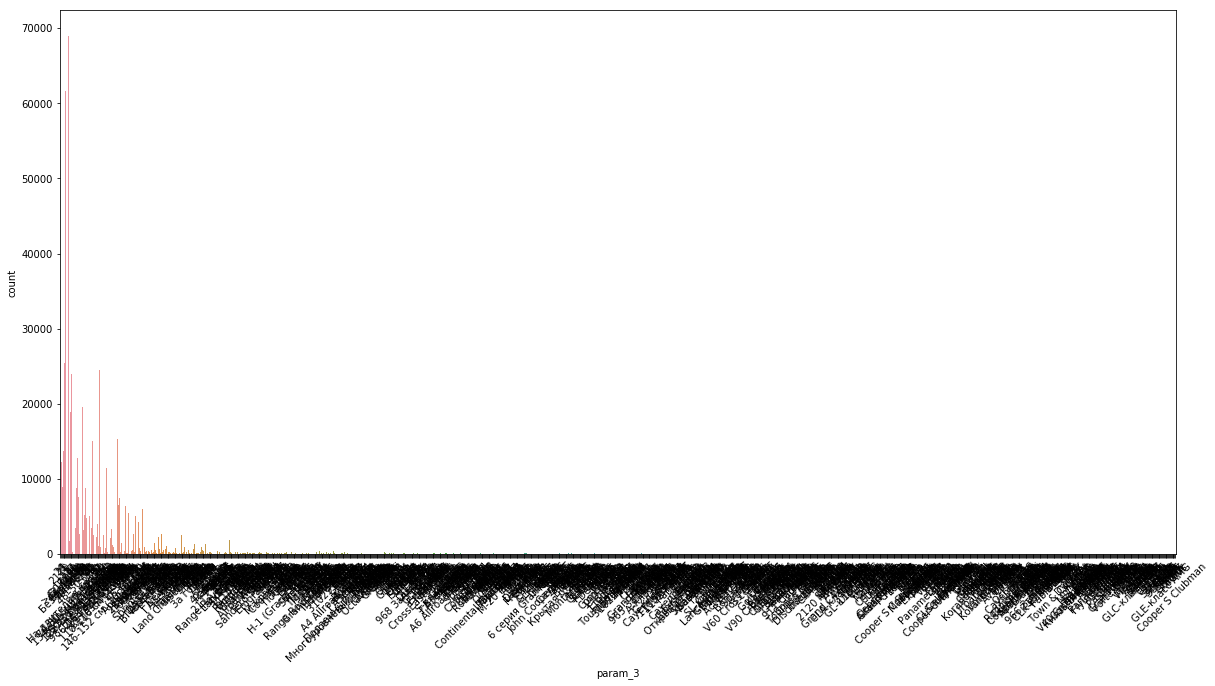

In [33]:
print('# of category : ', len(df_all.param_3.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_all.param_3, data=df_all)
plt.show()

# item_seq_number

# of category :  33947


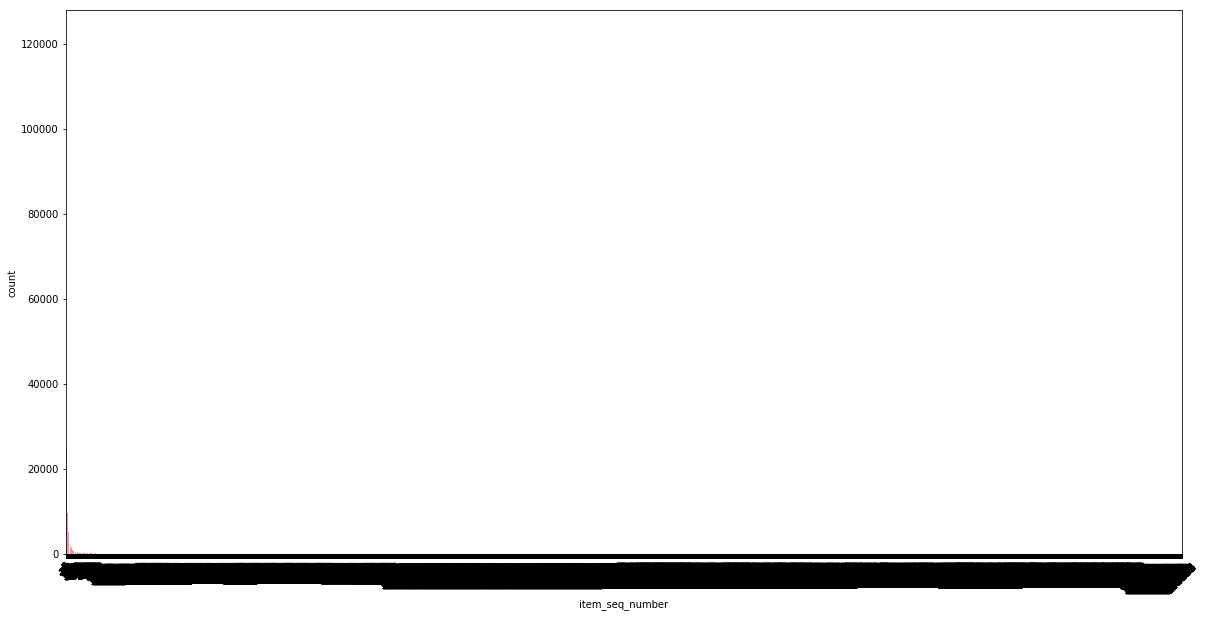

In [34]:
print('# of category : ', len(df_all.item_seq_number.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_all.item_seq_number, data=df_all)
plt.show()

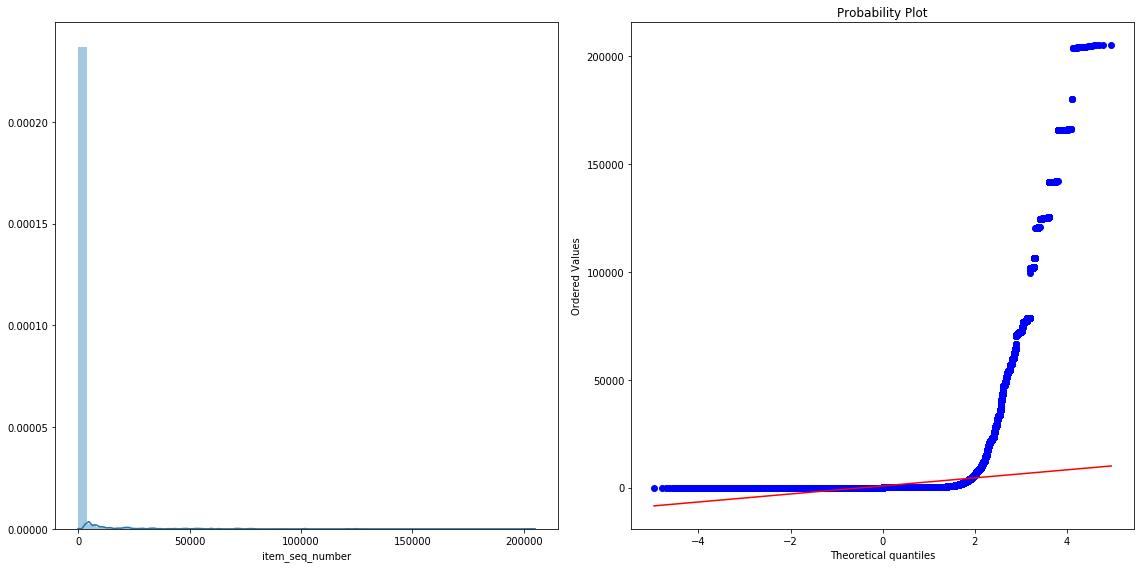

In [35]:
#logigramatic trip duration data#logigra 
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.distplot(df_all.item_seq_number.dropna())
plt.subplot(122)
stats.probplot(df_all.item_seq_number.dropna(), plot=plt)
plt.tight_layout()
plt.show()

# user_type

# of category :  3


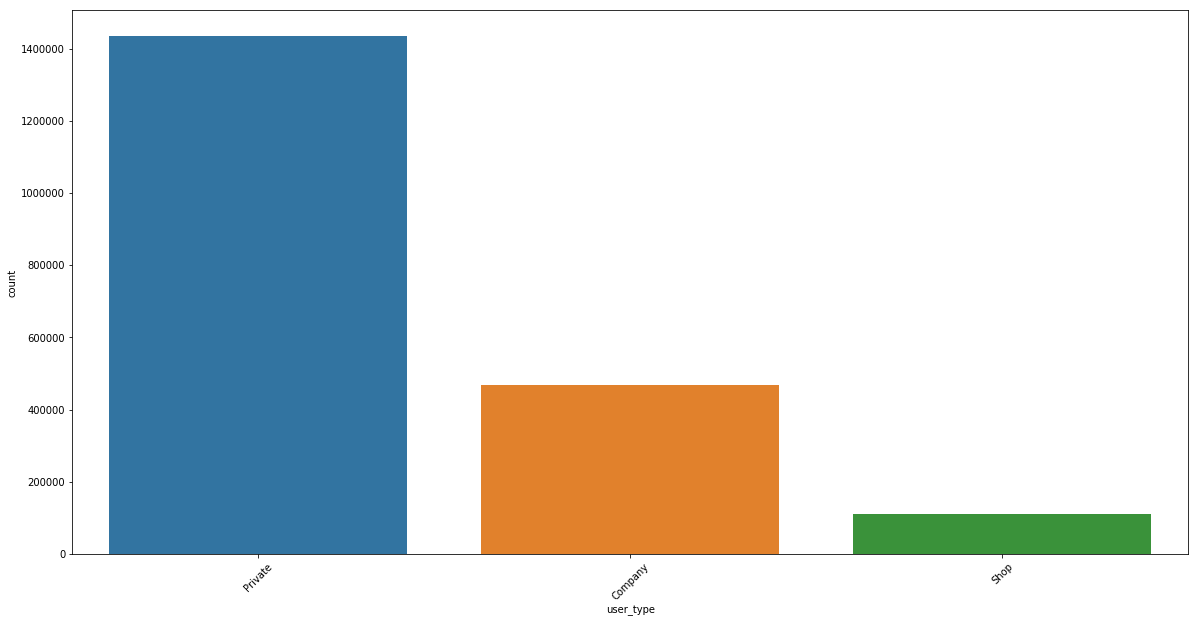

In [36]:
print('# of category : ', len(df_all.user_type.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_all.user_type, data=df_all)
plt.show()

# image_top_1

# of category :  3063


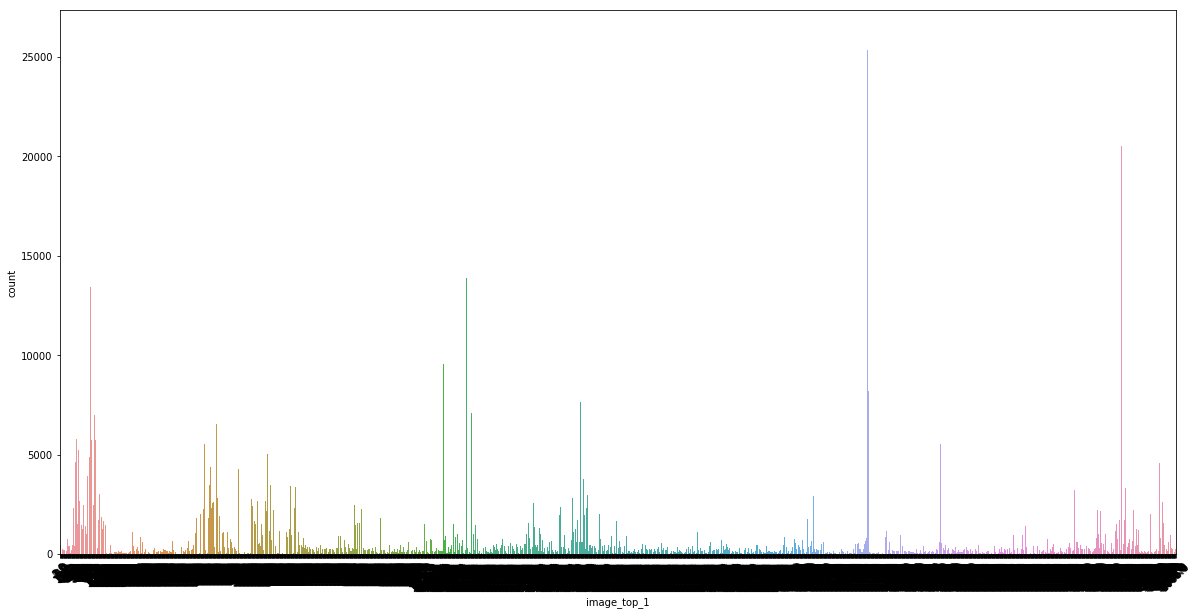

In [37]:
print('# of category : ', len(df_all.image_top_1.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_all.image_top_1, data=df_all)
plt.show()

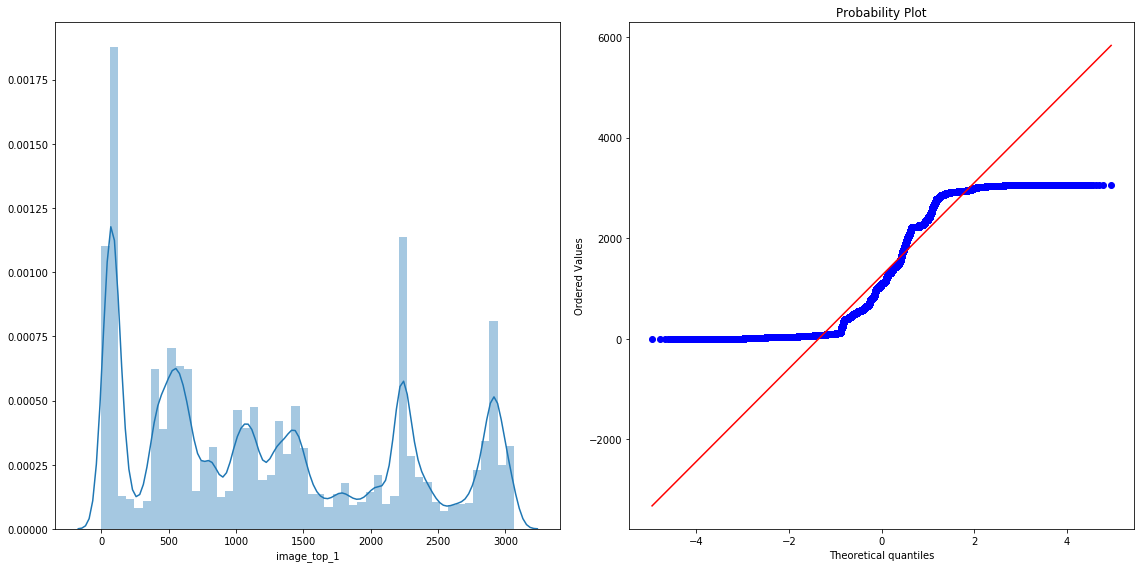

In [38]:
#logigramatic trip duration data#logigra 
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.distplot(df_all.image_top_1.dropna())
plt.subplot(122)
stats.probplot(df_all.image_top_1.dropna(), plot=plt)
plt.tight_layout()
plt.show()

# price

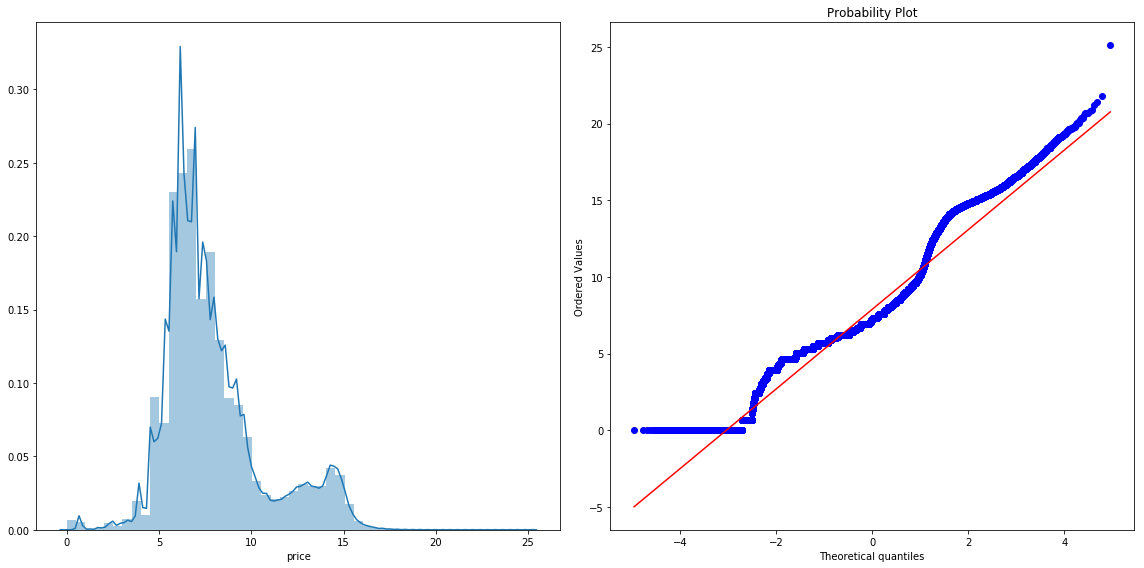

In [39]:
#logigramatic trip duration data#logigra 
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.distplot(np.log(df_all.price.dropna() + 1))
plt.subplot(122)
stats.probplot(np.log(df_all.price.dropna() + 1), plot=plt)
plt.tight_layout()
plt.show()

# missing values

In [40]:
df_train.isnull().sum()

item_id                      0
user_id                      0
region                       0
city                         0
parent_category_name         0
category_name                0
param_1                  61576
param_2                 654542
param_3                 862565
title                        0
description             116276
price                    85362
item_seq_number              0
activation_date              0
user_type                    0
image                   112588
image_top_1             112588
deal_probability             0
dtype: int64

In [41]:
df_all.isnull().sum()

activation_date               0
category_name                 0
city                          0
deal_probability         508438
description              116276
image                    155197
image_top_1              155197
item_id                       0
item_seq_number               0
param_1                   84486
param_2                  887771
param_3                 1168896
parent_category_name          0
price                    115947
region                        0
title                         0
user_id                       0
user_type                     0
dtype: int64

In [42]:
print('param_1     :', round(df_train.param_1.isnull().sum() / len(df_train), 2))
print('param_2     :', round(df_train.param_2.isnull().sum() / len(df_train), 2))
print('param_3     :', round(df_train.param_3.isnull().sum() / len(df_train), 2))
print('description :', round(df_train.description.isnull().sum() / len(df_train), 2))
print('price       :', round(df_train.price.isnull().sum() / len(df_train), 2))
print('image       :', round(df_train.image.isnull().sum() / len(df_train), 2))
print('image_top_1 :', round(df_train.image_top_1.isnull().sum() / len(df_train), 2))

param_1     : 0.04
param_2     : 0.44
param_3     : 0.57
description : 0.08
price       : 0.06
image       : 0.07
image_top_1 : 0.07


In [43]:
print('param_1     :', round(df_all.param_1.isnull().sum() / len(df_train), 2))
print('param_2     :', round(df_all.param_2.isnull().sum() / len(df_train), 2))
print('param_3     :', round(df_all.param_3.isnull().sum() / len(df_train), 2))
print('description :', round(df_all.description.isnull().sum() / len(df_train), 2))
print('price       :', round(df_all.price.isnull().sum() / len(df_train), 2))
print('image       :', round(df_all.image.isnull().sum() / len(df_train), 2))
print('image_top_1 :', round(df_all.image_top_1.isnull().sum() / len(df_train), 2))

param_1     : 0.06
param_2     : 0.59
param_3     : 0.78
description : 0.08
price       : 0.08
image       : 0.1
image_top_1 : 0.1


In [44]:
df_train.price.median()

1300.0

In [45]:
df_all.price.median()

1390.0

In [46]:
gc.collect()

367589

# translation by googletrans

In [47]:
from googletrans import Translator
translator = Translator()

In [48]:
new = df_all.copy()

In [49]:
para = "parent_category_name"

before = df_all[para].value_counts().index.astype(str)
after = []

print(len(before))

for i in range(len(before)):
    translator = Translator()
    temp = translator.translate(before[i]).text
    after.append(temp)
    
zip_para = dict(zip(before, after))

new[para] = new[para].replace(to_replace=zip_para)

9


In [50]:
para = "category_name"

before = df_all[para].value_counts().index.astype(str)
after = []

print(len(before))

for i in range(len(before)):
    translator = Translator()
    temp = translator.translate(before[i]).text
    after.append(temp)
    
zip_para = dict(zip(before, after))

new[para] = new[para].replace(to_replace=zip_para)

47


In [51]:
para = "param_1"

before = df_all[para].value_counts().index.astype(str)
after = []

print(len(before))

for i in range(len(before)):
    translator = Translator()
    temp = translator.translate(before[i]).text
    after.append(temp)
    
zip_para = dict(zip(before, after))

new[para] = new[para].replace(to_replace=zip_para)

371


In [52]:
para = "param_2"

before = df_train[para].value_counts().index.astype(str)
after = []

print(len(before))

for i in range(len(before)):
    translator = Translator()
    temp = translator.translate(before[i]).text
    after.append(temp)
    
zip_para = dict(zip(before, after))

new[para] = new[para].replace(to_replace=zip_para)

271


In [53]:
para = "param_3"

before = df_all[para].value_counts().index.astype(str)
after = []

print(len(before))

for i in range(len(before)):
    translator = Translator()
    temp = translator.translate(before[i]).text
    after.append(temp)
    
zip_para = dict(zip(before, after))

new[para] = new[para].replace(to_replace=zip_para)

1276


In [54]:
new.head()

,activation_date,category_name,city,deal_probability,description,image,image_top_1,item_id,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,title,user_id,user_type
0,2017-03-28,Goods for children and toys,Екатеринбург,0.12789,"Кокон для сна малыша,пользовались меньше месяц...",d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,b912c3c6a6ad,2,Bed dress,NaN,NaN,Personal things,400.0,Свердловская область,Кокоби(кокон для сна),e00f8ff2eaf9,Private
1,2017-03-26,Furniture and interior,Самара,0.00000,"Стойка для одежды, под вешалки. С бутика.",79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,2dac0150717d,19,Other,NaN,NaN,For home and cottages,3000.0,Самарская область,Стойка для Одежды,39aeb48f0017,Private
2,2017-03-20,Audio and video,Ростов-на-Дону,0.43177,"В хорошем состоянии, домашний кинотеатр с blu ...",b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,ba83aefab5dc,9,"Video, DVD and Blu-ray players",NaN,NaN,Consumer electronics,4000.0,Ростовская область,Philips bluray,91e2f88dd6e3,Private
3,2017-03-25,Goods for children and toys,Набережные Челны,0.80323,Продам кресло от0-25кг,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,02996f1dd2ea,286,Car seats,NaN,NaN,Personal things,2200.0,Татарстан,Автокресло,bf5cccea572d,Company
4,2017-03-16,Cars,Волгоград,0.20797,Все вопросы по телефону.,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,7c90be56d2ab,3,With mileage,VAZ (LADA),2110,Transport,40000.0,Волгоградская область,"ВАЗ 2110, 2003",ef50846afc0b,Private


In [55]:
gc.collect()

189

# translated russian to english example

In [56]:
paras = ['parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', 'title', 'description']
df1 = pd.DataFrame(columns=paras)

for para in paras:
    
    after = []
    
    for i in range(7,11):
        translator = Translator()
        temp = translator.translate(df_train[para][i]).text
        after.append(temp)
    df1[para] = after
        
df1

,parent_category_name,category_name,param_1,param_2,param_3,title,description
0,Personal things,"Clothes, shoes, accessories",Women's clothing,Jeans,26,Boyfriends colins,Boyfriends in good condition.
1,Personal things,"Clothes, shoes, accessories",Women's clothing,Dresses and skirts,> 50 (XXL),Dress,54 times very convenient
2,Personal things,Children's clothing and footwear,For girls,Footwear,25,Half botinchka zamš natur.Bambini,On the insole 15.5cm measure the Prioksky area...
3,The property,Apartments,Rent,For a long time,1,"1-to the apartment, 25 m ², 2/2 fl.",One bedroom furnished apartment for rent. The ...


In [57]:
paras = ['parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', 'title', 'description']
df2 = pd.DataFrame(columns=paras)

for para in paras:
    
    after = []
    
    for i in range(18,23):
        translator = Translator()
        temp = translator.translate(df_train[para][i]).text
        after.append(temp)
    df2[para] = after
        
df2

,parent_category_name,category_name,param_1,param_2,param_3,title,description
0,Personal things,"Clothes, shoes, accessories",Women's clothing,Outerwear,44–46 (M),Spring jacket (autumn),"The jacket is new, very comfortable, the price..."
1,The property,"Houses, cottages, cottages",Hire,Cottage,For a long time,Hire a cottage,A married couple of two people will remove the...
2,The property,Apartments,Selling,2,Secondary,"2-to the apartment, 44 m ², 5/5 fl.",The house is located inside the block.\nPlasti...
3,Personal things,"Clothes, shoes, accessories",Women's clothing,Outerwear,> 50 (XXL),Hat norwokaya,"Selling a hat, mink, brown color, in excellent..."
4,Transport,Cars,With mileage,Ford,Focus,"Ford Focus, 2005",Full set. GUR. 4 esp. Heated seats of rear-vie...


In [58]:
gc.collect()

532

# date time convert

In [59]:
df_all["activation_date"] = pd.to_datetime(df_all["activation_date"], format = "%Y-%m-%d")

In [60]:
df_all['active_year'] = df_all["activation_date"].apply(lambda x : x.year)
df_all['active_month'] = df_all["activation_date"].apply(lambda x : x.month)
df_all['active_day'] = df_all["activation_date"].apply(lambda x : x.day)

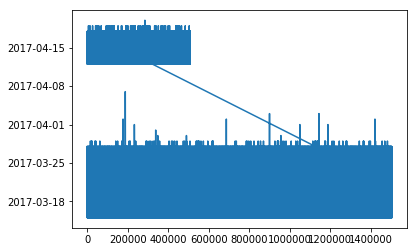

In [61]:
# df3 = pd.DataFrame(randn(1000, 2), columns=['B', 'C']).cumsum()
# df3['A'] = Series(list(range(len(df))))
df_all.activation_date.plot()

# Tf-idf

In [ ]:
print("\nText Features")

# Feature Engineering 

# Meta Text Features
textfeats = ["description", "title"]
df['desc_punc'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words
    

print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}

In [ ]:
def get_col(col_name): return lambda x: x[col_name]
##I added to the max_features of the description. It did not change my score much but it may be worth investigating
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=17000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('title',CountVectorizer(
            ngram_range=(1, 2),
            stop_words = russian_stop,
            #max_features=7000,
            preprocessor=get_col('title')))
    ])

In [ ]:
start_vect=time.time()

#Fit my vectorizer on the entire dataset instead of the training rows
#Score improved by .0001
vectorizer.fit(df.to_dict('records'))

ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

# Drop Text Cols
textfeats = ["description", "title"]
df.drop(textfeats, axis=1,inplace=True)